# **State Bank of India price prediction using ARIMA Model**

## Importing Libraries

In [112]:
!pip install yfinance


import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline
import prophet
yf.pdr_override()
import numpy as np 
import pandas as pd 
import os
from numpy import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import datetime
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## State Bank of India Stock Market Analyis

In [113]:
from datetime import datetime

df = pdr.get_data_yahoo('SBIN.NS', start='2014-01-01', end=datetime.now())

#df['new_column'] = range(0, len(df))
df= df.reset_index()
#df = df.set_index('new_column')
#df = df.reset_index(drop=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-01,177.199997,177.490005,176.125000,176.505005,163.925034,5904780
1,2014-01-02,176.589996,180.600006,173.220001,174.259995,161.840027,19451900
2,2014-01-03,172.699997,173.600006,171.100006,171.964996,159.708603,13759590
3,2014-01-06,172.190002,172.399994,168.199997,168.815002,156.783157,13907830
4,2014-01-07,169.289993,170.199997,165.500000,166.139999,154.298798,17352910


In [114]:
print(df.shape)
print(df.columns)

(2301, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2301 entries, 0 to 2300
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2301 non-null   datetime64[ns]
 1   Open       2301 non-null   float64       
 2   High       2301 non-null   float64       
 3   Low        2301 non-null   float64       
 4   Close      2301 non-null   float64       
 5   Adj Close  2301 non-null   float64       
 6   Volume     2301 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 126.0 KB


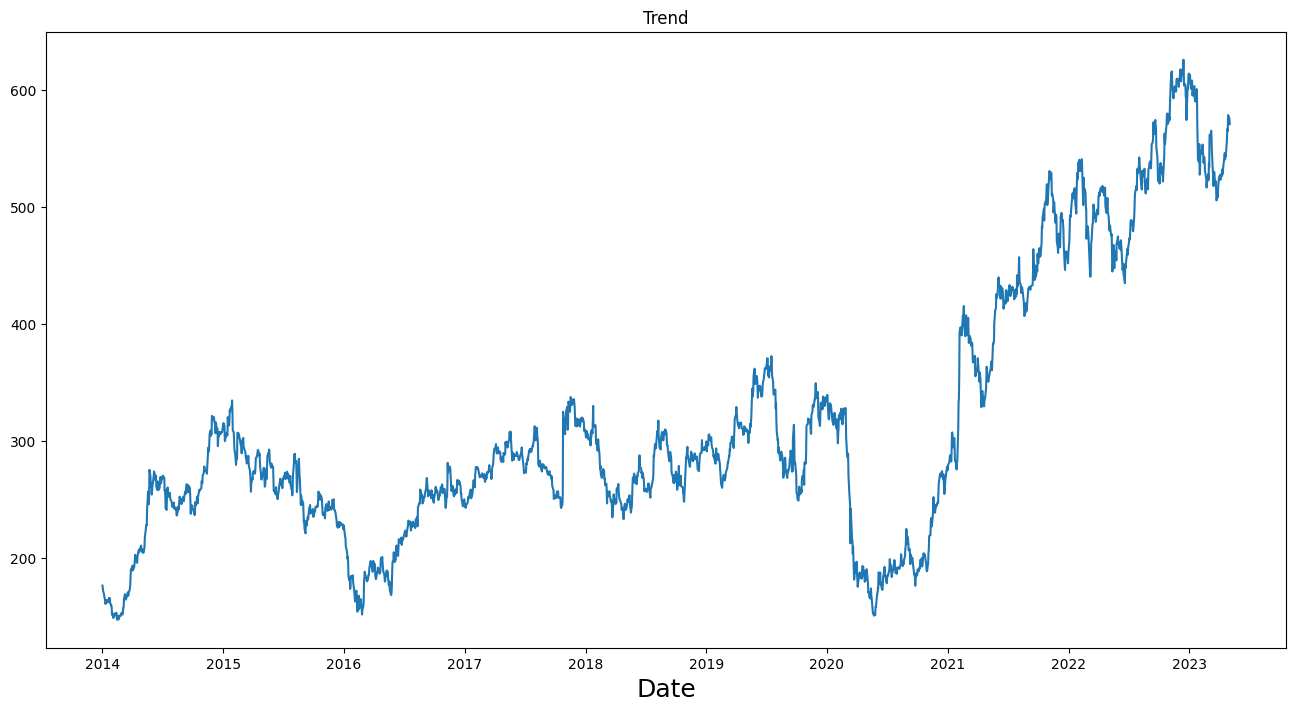

In [116]:
plt.figure(figsize=(16,8))
plt.plot(df['Date'],df['Close'])
plt.title('Trend')
plt.xlabel('Date', fontsize=18)
plt.show()

In [117]:
### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller

In [118]:
test_result = adfuller(df['Close'])

In [119]:
#H0: It is non stationary
#H1: It is stationary

def adfuller_test(close):
  result = adfuller(close)
  labels = ['ADF Test Statistics','p-value','#Lags Used','Number of Observations Used']
  for value,label in zip(result,labels):
    print(label+' : '+str(value))
  if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis(H0), reject the null hypothesis,i.e. data is stationary")
  else:
    print("Weak evidence against the null hypothesis(H0), means accept the null hypothesis, i.e. data is non stationary")

In [120]:
adfuller_test(df['Close'])

ADF Test Statistics : -0.891431659868327
p-value : 0.7907809973829055
#Lags Used : 6
Number of Observations Used : 2294
Weak evidence against the null hypothesis(H0), means accept the null hypothesis, i.e. data is non stationary


In [121]:
df['Close_shift'] = df['Close'] - df['Close'].shift(1)

In [122]:
df['Close_shift'] = df['Close_shift'].fillna(method='bfill')
df['Close_shift']

0       -2.245010
1       -2.245010
2       -2.294998
3       -3.149994
4       -2.675003
          ...    
2296     4.549988
2297    -1.599976
2298    13.549988
2299    -3.000000
2300    -4.799988
Name: Close_shift, Length: 2301, dtype: float64

In [123]:
test_result = adfuller(df['Close_shift'])

In [124]:
#H0: It is non stationary
#H1: It is stationary

def adfuller_test(close):
  result = adfuller(close)
  labels = ['ADF Test Statistics','p-value','#Lags Used','Number of Observations Used']
  for value,label in zip(result,labels):
    print(label+' : '+str(value))
  if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis(H0), reject the null hypothesis,i.e. data is stationary")
  else:
    print("Weak evidence against the null hypothesis(H0), means accept the null hypothesis, i.e. data is non stationary")

In [125]:
adfuller_test(df['Close_shift'])

ADF Test Statistics : -19.166159254809298
p-value : 0.0
#Lags Used : 5
Number of Observations Used : 2295
Strong evidence against the null hypothesis(H0), reject the null hypothesis,i.e. data is stationary


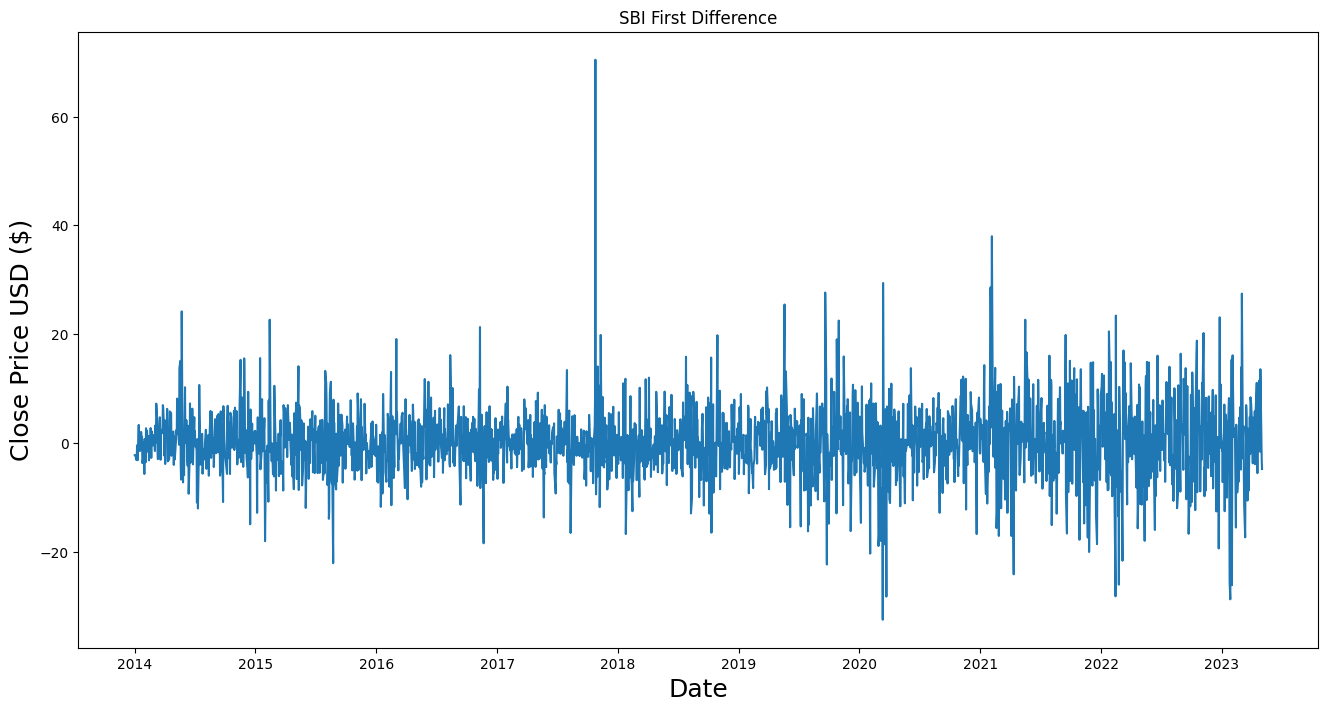

In [126]:
plt.figure(figsize=(16,8))
plt.plot(df['Date'],df['Close_shift'])
plt.title("SBI First Difference")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## **Auto Regressive Model**
### **Final Thoughts on Autocorrelation and Partial Autocorrelation**

1.   Identification of an AR model is often best done with the PACF
-- For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.


2.   Identification of an MA model is often best done with the ACF rather than the PACF.
-- For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

p,d,q. AR model - p, differencing - d, MA lags - q



In [127]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

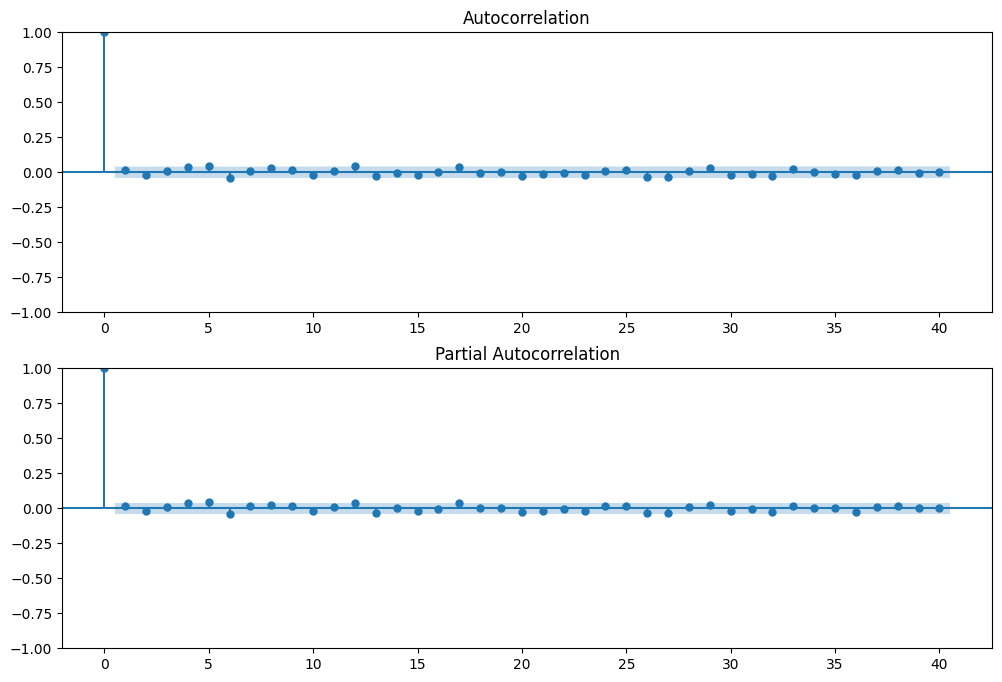

In [128]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Close_shift'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Close_shift'].iloc[1:],lags=40,ax=ax2)

## ARIMA (AutoRegressive Integrated Moving Average) for Time Series Prediction

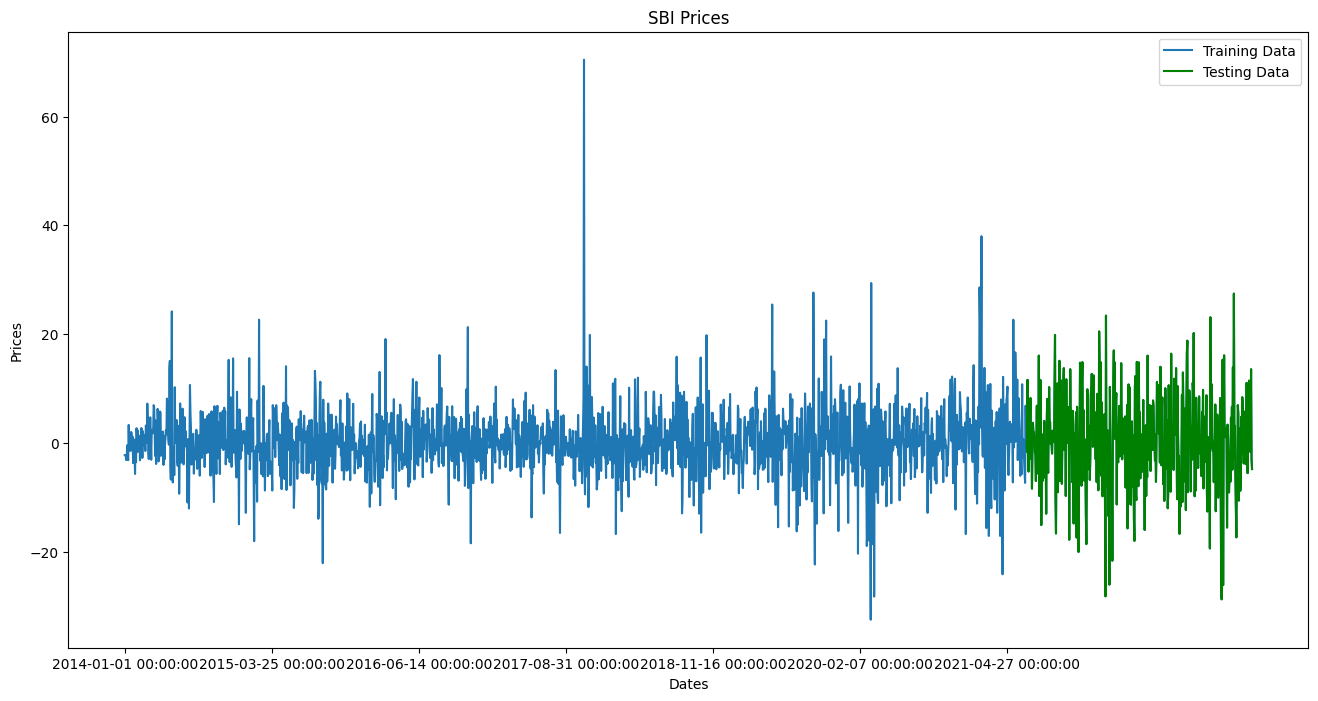

In [129]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(16,8))
plt.title('SBI Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close_shift'], label='Training Data')
plt.plot(test_data['Close_shift'], 'green', label='Testing Data')
plt.xticks(np.arange(0,1857, 300), df['Date'][0:2000:300])
plt.legend()

In [130]:
#p=1, d=0, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [131]:
#model=ARIMA(train_data['Close_shift'],order=(1,1,1))
import statsmodels.api as sm

model=sm.tsa.arima.ARIMA(df['Close_shift'],order=(1,0,1))
model_fit=model.fit()

In [132]:
#model_fit.summary()

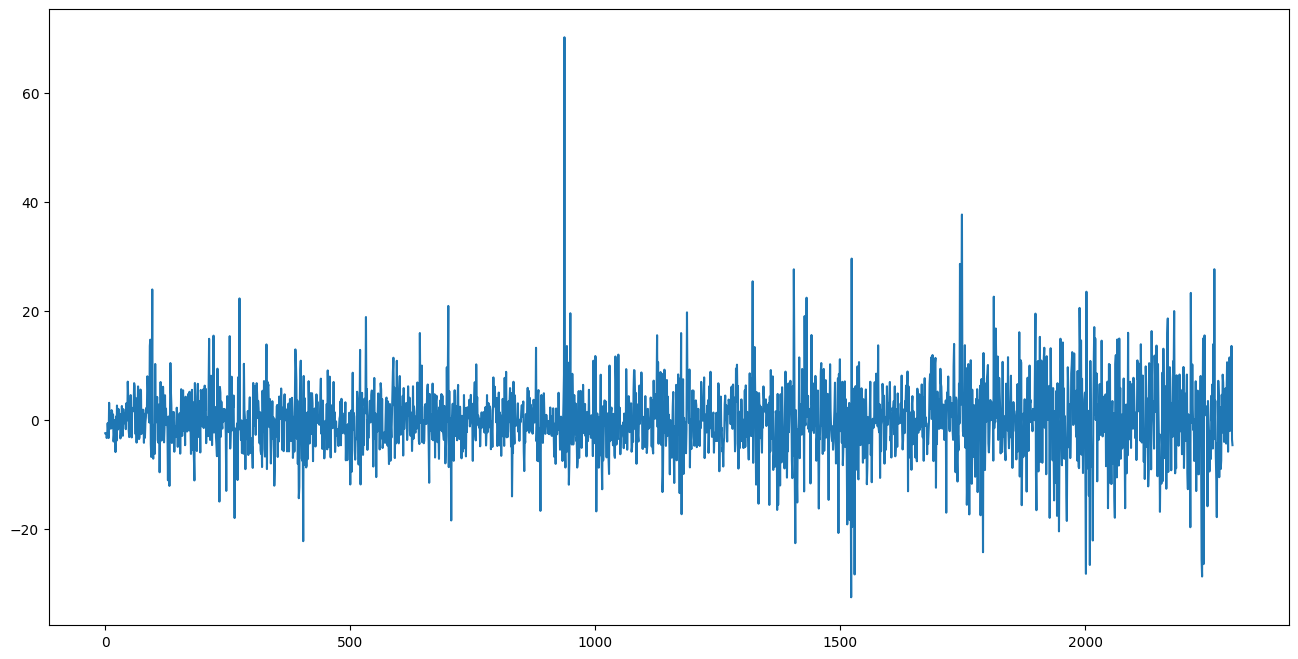

In [133]:
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
plt.figure(figsize=(16,8))
#residuals.plot()
plt.plot(residuals)

<Axes: ylabel='Density'>

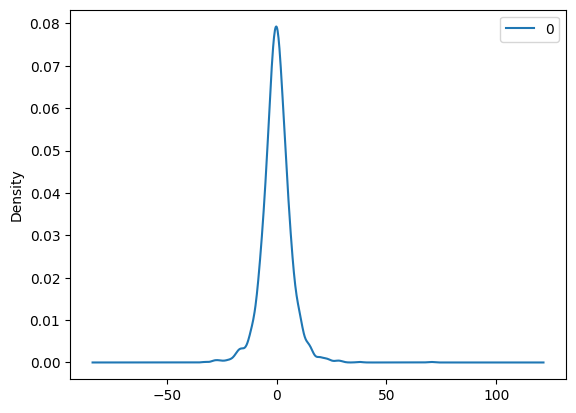

In [134]:
residuals.plot(kind='kde')

In [135]:
residuals.describe()

,0
count,2301.000000
mean,0.000003
std,6.553235
min,-32.487797
25%,-3.409200
50%,-0.104830
75%,3.321323
max,70.163405


In [136]:
train_arima = train_data['Close_shift'].values
test_arima = test_data['Close_shift'].values

In [137]:
#p_values = range(0,4)
#d_values = range(0,3)
#q_values = range(0,2)

In [138]:
# Way-1
#import itertools
#pdq = list(itertools.product(p_values,d_values,q_values))
#pdq

In [139]:
#import warnings
#warnings.filterwarnings('ignore')
#for param in pdq:
#  for i in range(len(test_arima)):
#        try:
#          model = ARIMA(trin_arima,order=param)
#          model_fit = model.fit(disp=0)
#          pred_y = model_fit.forecast()[0]
#          predictions.append(pred_y)
#          error = mean_sqared-error(test, predictions)
#          print(model_fit.aic)
#          print("ARIMA%s, MSE=0.2, RMSE=0.2"% (order,error,math.sqrt(error)))
#        except:
#          continue

In [140]:
#for p in p_values:
#  for d in d_values:
#    for q in q_values:
#      order = (p,d,q)
#      train, test = train_arima, test_arima
#      predictions = list()
#      for i in range(len(test_arima)):
#        try:
#          model = ARIMA(train_arima,order)
#          model_fit = model.fit(disp=0)
#          pred_y = model_fit.forecast()[0]
#          predictions.append(pred_y)
#          error = mean_sqared-error(test_arima, predictions)
#          print("ARIMA%s, MSE=0.2, RMSE=0.2"% (order,error,math.sqrt(error)))
#        except:
#          continue


In [141]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
history = [x for x in train_arima]
print(type(history))
predictions = list()
for t in range(len(test_arima)):
    model = sm.tsa.arima.ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.predict(start=len(train_arima)+t-1, end = len(train_arima)+t,dynamic=True)
    #output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_arima[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_arima, predictions)
print('MSE : %.3f' % error)
error2 = math.sqrt(error)
print('RMSE : %.3f' % error2)

<class 'list'>
MSE : 105.701
RMSE : 10.281


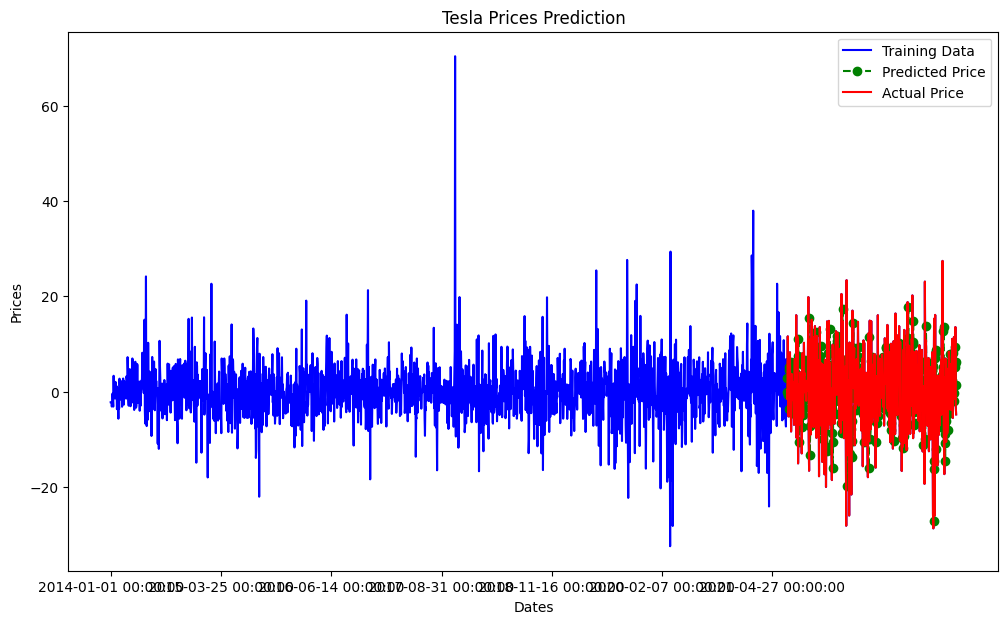

In [142]:
plt.figure(figsize=(12,7))
plt.plot(df['Close_shift'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close_shift'], color='red', label='Actual Price')
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,1857, 300), df['Date'][0:1857:300])
plt.legend()

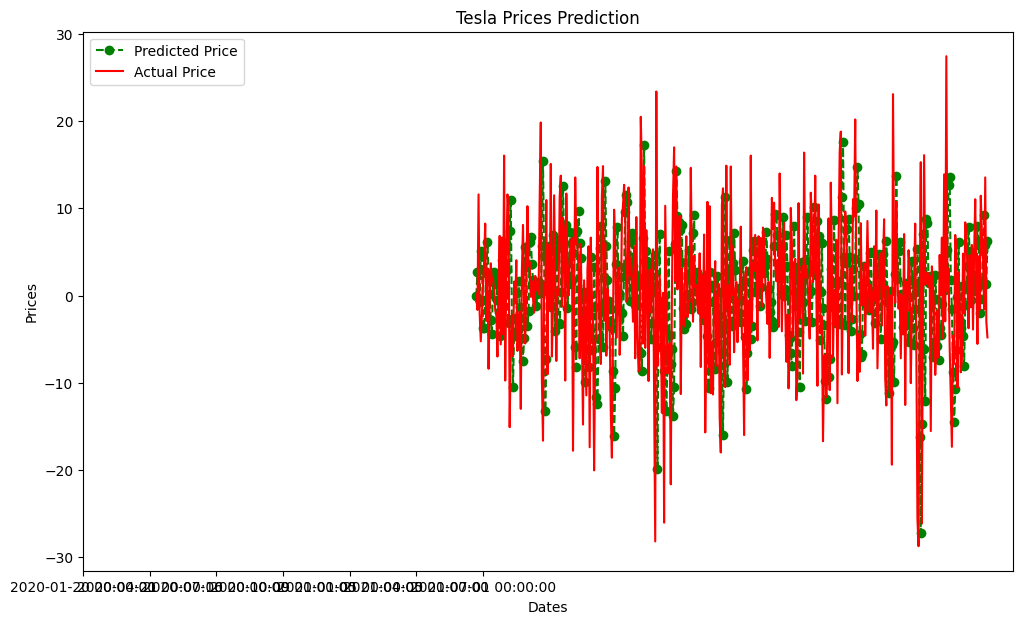

In [143]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close_shift'], color='red', label='Actual Price')
plt.xticks(np.arange(1486,1856, 60), df['Date'][1486:1856:60])
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()